In [119]:
import sys
import re
import datetime
from math import log
import csv
import pprint
import math
import random
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pandas as pd
from elasticsearch import Elasticsearch, helpers

from __future__ import division

%matplotlib inline

np.set_printoptions(threshold=sys.maxint)
pd.set_option('display.max_rows', 1000)

pp = pprint.PrettyPrinter()

In [120]:
#es = Elasticsearch([{'host': 'hcc-metrics.unl.edu', 'port': 9200}])
username = 'cms'
password = 'B3A96-D0g_PkkPz5'
es = Elasticsearch([{'host': 'es-cms.cern.ch', 'port': 9203, 'http_auth': username+':'+password}], use_ssl=True,verify_certs=True,ca_certs="ca-bundle.trust.crt")

In [121]:
indices = es.cat.indices(index="cms-*", h="index", request_timeout=600).split('\n')
indices = sorted(indices)
indices = [x for x in indices if x != '']

In [122]:
def time_filter(indices, days=0, until=0):
    if days == 0:
        return ["cms-*"]
    today = datetime.date.today()
    filtered = []
    datefmt = '%Y-%m-%d'
    for i in indices:
        day = re.sub(r'cms-', '', i).rstrip()
        day = datetime.datetime.strptime(day, datefmt).date()
        diff = today - day
        if until <= diff.days < days + until:
            filtered.append(i.rstrip())
    return filtered

In [123]:
# Change second argument to use a different time range for ES queries
ind = time_filter(indices, 0, 0)
ind = ','.join(ind)

These variables are used:
* **RequestCpus**: number of cores used by the job
* **CpuTimeHr**: CPU time used by the job (hours)
* **WallClockHr**: wall-clock time used by the job (hours)
* **CoreHr**: wall-clock time used by the job times the number of cores (hours)
* **CpuEff**: CPU efficiency (%)
* **Type**: type of job (production or analysis)
* **Status**: job status (completed, running, idle, removed, held)
* **TaskType**: task type (analysis, production, merge, digireco, repack, reco, cleanup, logcollect, miniaod, express, dataprocessing, gensim, etc.)
* **Site**: site assigned to the job
* **Workflow**: workflow name
* **Kevents**: thousands of events in the job (often not reported by all versions of CMSSW)
* **InputGB**: amount of data read by job (GB)
* **OutputGB**: amount of data written by job (GB)

In [124]:
s2 = {
    "size": 0,
    "query": {
        "filtered": {
            "filter": {
                "bool": {
                    "filter": [
                        {
                            "range": {
                                "CpuTimeHr": {"gt": 0.}
                            }
                        },
                        {
                            "range": {
                                "CoreHr": {"gt": 0.}
                            }
                        },
                        { 
                            "range": {
                                "KEvents": {"gt": 0.}
                            }
                        },
                        {
                            "match": {
                                "Status": "completed"
                            }
                        }
                    ],
                    "must_not": [
                        {
                            "query": {
                                "match": {
                                    "TaskType": "merge"
                                }
                            }
                        },
                        {
                            "query": {
                                "match": {
                                    "TaskType": "logcollect"
                                }
                            }
                        },
                        {
                            "query": {
                                "match": {
                                    "TaskType": "cleanup"
                                }
                            }
                        }
                    ]
                }
            }
        }
    },
    "aggs": {
        "ttypes": {
            "terms": {
                "field": "TaskType",
                "size": 1000
            },
            "aggs": {
                "site": {
                    "terms": {
                        "field": "Site",
                        "size": 1000
                    },
                    "aggs": {
                        "wf": {
                            "terms": {
                                "field": "Workflow",
                                "size": 100000
                            },
                            "aggs": {
                                "type": {
                                    "terms": {
                                        "field": "Type",
                                        "size": 10
                                    },
                                    "aggs": {
                                        "1": {
                                            "extended_stats": {
                                                "script": "doc['KEvents'].value > 0 ? doc['CpuTimeHr'].value / doc['KEvents'].value * 3.6 : 0",
                                                "lang": "expression"
                                            }
                                        },
                                        "2": {
                                            "extended_stats": {
                                                "script": "doc['KEvents'].value > 0 ? doc['CoreHr'].value / doc['KEvents'].value * 3.6 : 0",
                                                "lang": "expression"
                                            }
                                        },
                                        "3": {
                                            "sum": {
                                                "field": "CpuTimeHr"
                                            }
                                        },
                                        "4": {
                                            "sum": {
                                                "field": "CoreHr"
                                            }
                                        },
                                        "6": {
                                            "avg": {
                                                "field": "RequestCpus"
                                            }
                                        },
                                        "7": {
                                            "sum": {
                                                "script": "(doc['KEvents'].value) ? doc['KEvents'].value * 1000 : 0",
                                                "lang": "expression"
                                            }
                                        },
                                        "8": {
                                            "avg": {
                                                "field": "CpuEff"
                                            }
                                        },
                                        "9": {
                                            "avg": {
                                                "script": "doc['RequestCpus'].value > 0 ? doc['MemoryMB'].value / doc['RequestCpus'].value : 0",
                                                "lang": "expression"
                                            }
                                        },
                                        "10": {
                                            "avg": {
                                                "field": "InputGB"
                                            }
                                        },
                                        "11": {
                                            "avg": {
                                                "field": "OutputGB"
                                            }
                                        },
                                        "12": {
                                            "avg": {
                                                "script": "doc['KEvents'].value > 0 ? doc['InputGB'].value / doc['KEvents'].value : 0",
                                                "lang": "expression"
                                            }
                                        },
                                        "13": {
                                            "avg": {
                                                "script": "doc['KEvents'].value > 0 ? doc['OutputGB'].value / doc['KEvents'].value : 0",
                                                "lang": "expression"
                                            }
                                        },
                                        "14": {
                                            "avg": {
                                                "script": "doc['InputGB'].value < 0 ? 0 : (doc['CoreHr'].value > 0 ? doc['InputGB'].value / doc['CoreHr'].value / 3.6 : 0)",
                                                "lang": "expression"
                                            }
                                        }
                                    }
                                }
                            }
                        }
                    }
                }
            }
        }
    }
}

res = es.search(index=ind, body=s2, request_timeout=12000)

In [125]:
output_file = 'task_cms_90d_es.csv'

In [126]:
with open(output_file, 'w') as f:
    writer = csv.writer(f, lineterminator='\n')
    buckets1 = res['aggregations']['ttypes']['buckets']
    for b1 in buckets1:
        ttype = b1['key']
        buckets2 = b1['site']['buckets']
        for b2 in buckets2:
            site = b2['key']
            buckets3 = b2['wf']['buckets']
            for b3 in buckets3:
                wf = b3['key']
                buckets4 = b3['type']['buckets']
                for b4 in buckets4:
                    typ = b4['key']
                    writer.writerow([
                        wf,
                        ttype,
                        site,
                        typ,
                        b4['1']['count'],           # no. of jobs in request
                        b4['1']['avg'],             # average of CPU time per event
                        b4['1']['std_deviation'],   # standard deviation of CPU time per event
                        b4['2']['avg'],             # average of wall-clock time times cores per event
                        b4['2']['std_deviation'],   # standard deviation of wall-clock time times cores per event
                        b4['3']['value'] * 3600.,   # total CPU time (seconds)
                        b4['4']['value'] * 3600.,   # total wall-clock time times cores (seconds)
                        b4['6']['value'],           # cores
                        b4['7']['value'],           # events (thousands)
                        b4['8']['value'],           # CPU efficiency (%)
                        b4['9']['value'],           # Memory usage per core (MB)
                        b4['10']['value'] * 1000.,  # Input data (MB)
                        b4['11']['value'] * 1000.,  # Output data (MB)
                        b4['12']['value'],          # Output data per event (MB)
                        b4['13']['value'],          # Output data per event (MB)
                        b4['14']['value']           # Input data rate (MB/sec)
                        ])

In [134]:
input_file = 'task_cms_90d_es.csv'

In [138]:
df = pd.read_csv(input_file, dtype={'cpu_n': 'float'}, names=['request', 'tasktype', 'site', 'type',
                                                               'njobs', 'cpuevt_avg', 'cpuevt_rms', 'wallevt_avg',
                                                               'wallevt_rms', 'cpu', 'wc', 'cores', 'evts', 'eff', 'ramcore',
                                                               'input', 'output', 'inevt', 'outevt', 'inrate'])

In [139]:
df[df.type == 'production'][:10]

,request,tasktype,site,type,njobs,cpuevt_avg,cpuevt_rms,wallevt_avg,wallevt_rms,cpu,wc,cores,evts,eff,ramcore,input,output,inevt,outevt,inrate
97072,cerminar_run2016b-v2-singleelectron-23sep2016_...,dataprocessing,t1_us_fnal,production,20664,9.515209,4.835665,11.552603,19.132953,1.041995e+09,1.245492e+09,4.0,108003210.0,85.139758,1008.825161,3237.243908,1718.090783,0.613053,0.327265,0.057867
97073,cerminar_run2016e-v2-singleelectron-23sep2016_...,dataprocessing,t1_us_fnal,production,11938,13.115317,7.401793,15.506590,25.179910,8.079550e+08,9.457940e+08,4.0,60778401.0,87.454427,1037.276703,3465.429547,1816.724402,0.675778,0.353973,0.048800
97074,cerminar_run2016e-v2-singlemuon-23sep2016_8020...,dataprocessing,t1_us_fnal,production,9551,14.367737,20.061845,21.063021,93.467354,6.083851e+08,7.127549e+08,4.0,46377005.0,87.002004,1111.887001,3370.952390,2241.874616,0.697100,0.539678,0.049473
97075,cerminar_run2016b-v2-doubleeg-23sep2016_8020_1...,dataprocessing,t1_us_fnal,production,8724,9.472596,4.493784,11.981389,16.647309,4.392855e+08,5.406164e+08,4.0,47066427.0,83.702213,1014.811019,3416.806980,1703.580754,0.634950,0.320427,0.059622
97076,cerminar_run2016e-v2-jetht-23sep2016_8020_1609...,dataprocessing,t1_us_fnal,production,7415,15.958665,5.928248,18.812469,11.715940,5.043819e+08,5.947053e+08,4.0,33484191.0,88.117371,1041.756750,3301.140002,2998.222044,0.744184,0.687088,0.044746
97077,cerminar_run2016b-v2-tau-23sep2016_8020_160923...,dataprocessing,t1_us_fnal,production,7368,10.252894,3.163208,12.074377,9.350150,4.109161e+08,4.793674e+08,4.0,40607024.0,87.235281,961.077519,3806.013680,1194.830774,0.692888,0.218512,0.061614
97078,cerminar_run2016b-v2-singlephoton-23sep2016_80...,dataprocessing,t1_us_fnal,production,7013,9.903482,8.079782,12.624047,35.694341,3.738335e+08,4.371372e+08,4.0,38382065.0,84.980542,967.209430,3560.747168,3260.956030,0.641578,0.593819,0.059302
97079,cerminar_run2016d-v2-jetht-23sep2016_8020_1609...,dataprocessing,t1_us_fnal,production,6963,13.112093,4.018037,15.882309,11.308522,4.511505e+08,5.418484e+08,4.0,34603155.0,87.191619,1029.126223,3484.562661,3025.578136,0.701202,0.611257,0.049026
97080,cerminar_run2016b-v2-jetht-23sep2016_8020_1610...,dataprocessing,t1_us_fnal,production,6262,11.297143,12.084679,15.595338,33.475048,3.428522e+08,4.598203e+08,4.0,31200673.0,79.824267,1019.015372,3136.872738,2889.519315,0.635959,0.585695,0.047694
97081,prozober_acdc_run2016b-v2-singleelectron-23sep...,dataprocessing,t1_us_fnal,production,5692,9.886753,8.295312,13.004979,36.985619,2.666089e+08,3.170093e+08,4.0,27136014.0,84.677238,1001.190509,2964.747056,1572.474355,0.614487,0.338227,0.056250


## Preliminary data exploration

In [142]:
grouped = df.groupby(['tasktype'], as_index=False)
a = grouped.agg({'request': 'nunique', # ok!
                 'cpuevt_avg' : 'mean',   # wrong!
                 'wallevt_avg': 'mean',   # wrong!
                 'wc': 'sum',             # ok!
                 'cores': 'mean',         # wrong!
                 'njobs': 'sum',          # ok!
                 'evts': 'sum',           # ok!
                 'inrate': 'mean'
                })
a.sort_values('wc', ascending=False)

,tasktype,inrate,cpuevt_avg,wc,cores,wallevt_avg,evts,njobs,request
10,dataprocessing,0.063958,18.370822,9.453675e+10,4.000000,58.215408,6.435680e+09,1525226,503
6,analysis,0.708341,8.435921,6.129291e+10,1.035994,53.807511,3.497417e+11,8370417,11991
121,production,0.660616,34.827737,1.429780e+10,1.000000,73.259860,1.462210e+09,741047,18
34,digireco,0.256519,11.835812,1.994402e+09,3.409449,103.457251,1.076638e+08,70367,125
134,reco,0.085133,6.481285,7.513956e+08,1.155251,8.207775,5.040982e+07,35663,133
205,task1,0.081826,11.758133,7.439144e+08,1.000000,12.254581,5.023555e+07,23796,59
110,miniaod,0.191422,1.005965,3.371743e+08,1.000000,1.284310,2.716922e+08,70131,199
11,digi,2.999472,11.817677,2.038229e+08,1.000000,71.861333,0.000000e+00,14699,114
162,recofullglobalpu_2023d1pu,1.298393,408.939146,1.782286e+08,4.000000,591.644062,0.000000e+00,5114,1
90,hltdr2_2016,0.114718,6.320640,9.643501e+07,4.000000,8.036800,1.086350e+07,7515,2


## Average number  of jobs in request

2875.27730193


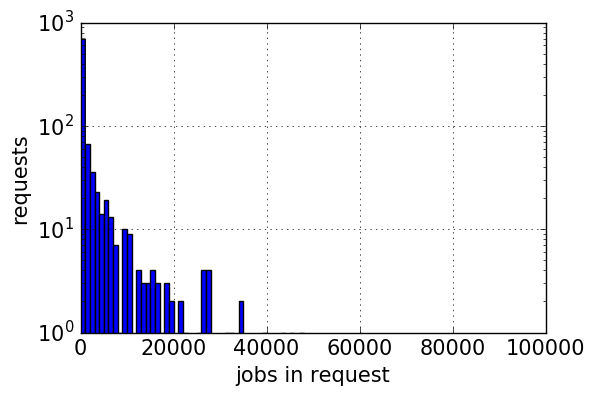

In [107]:
plt.rcParams.update({'font.size': 15})
grouped = df[df.type == 'production'].groupby(['request'], as_index=False)
a = grouped['njobs'].sum()
print np.mean(a['njobs'])
fig = a['njobs'].hist(bins=100, log=True, range=[0., 100000.])
plt.xlabel('jobs in request')
plt.ylabel('requests')

## Average number of events in request

281028.0


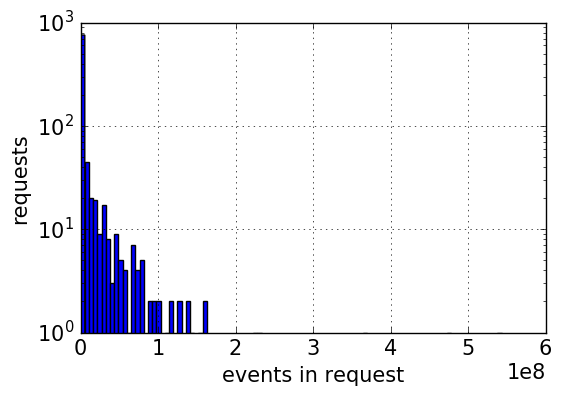

In [110]:
grouped = df[df.type == 'production'].groupby(['request'], as_index=False)
a = grouped['evts'].sum()
print np.median(a['evts'])
fig = a['evts'].hist(bins=100, log=True)
plt.xlabel('events in request')
plt.ylabel('requests')

## Average CPU efficiency of requests

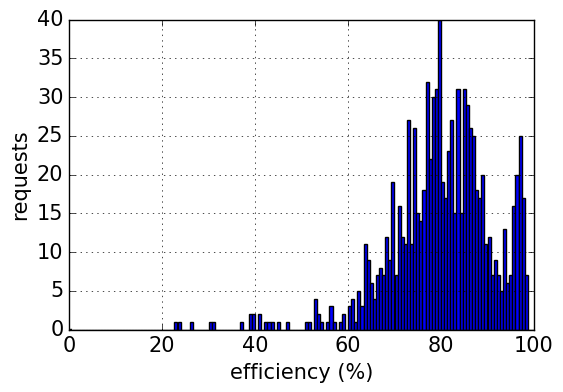

In [113]:
grouped = df[df.type == 'production'].groupby(['request'], as_index=False)
a = grouped['eff'].mean()
fig = a['eff'].hist(bins=150, log=False, range=(0, 100))   # NOT VERY CORRECT (arithmetic mean of efficiencies...)
plt.xlabel('efficiency (%)')
plt.ylabel('requests')

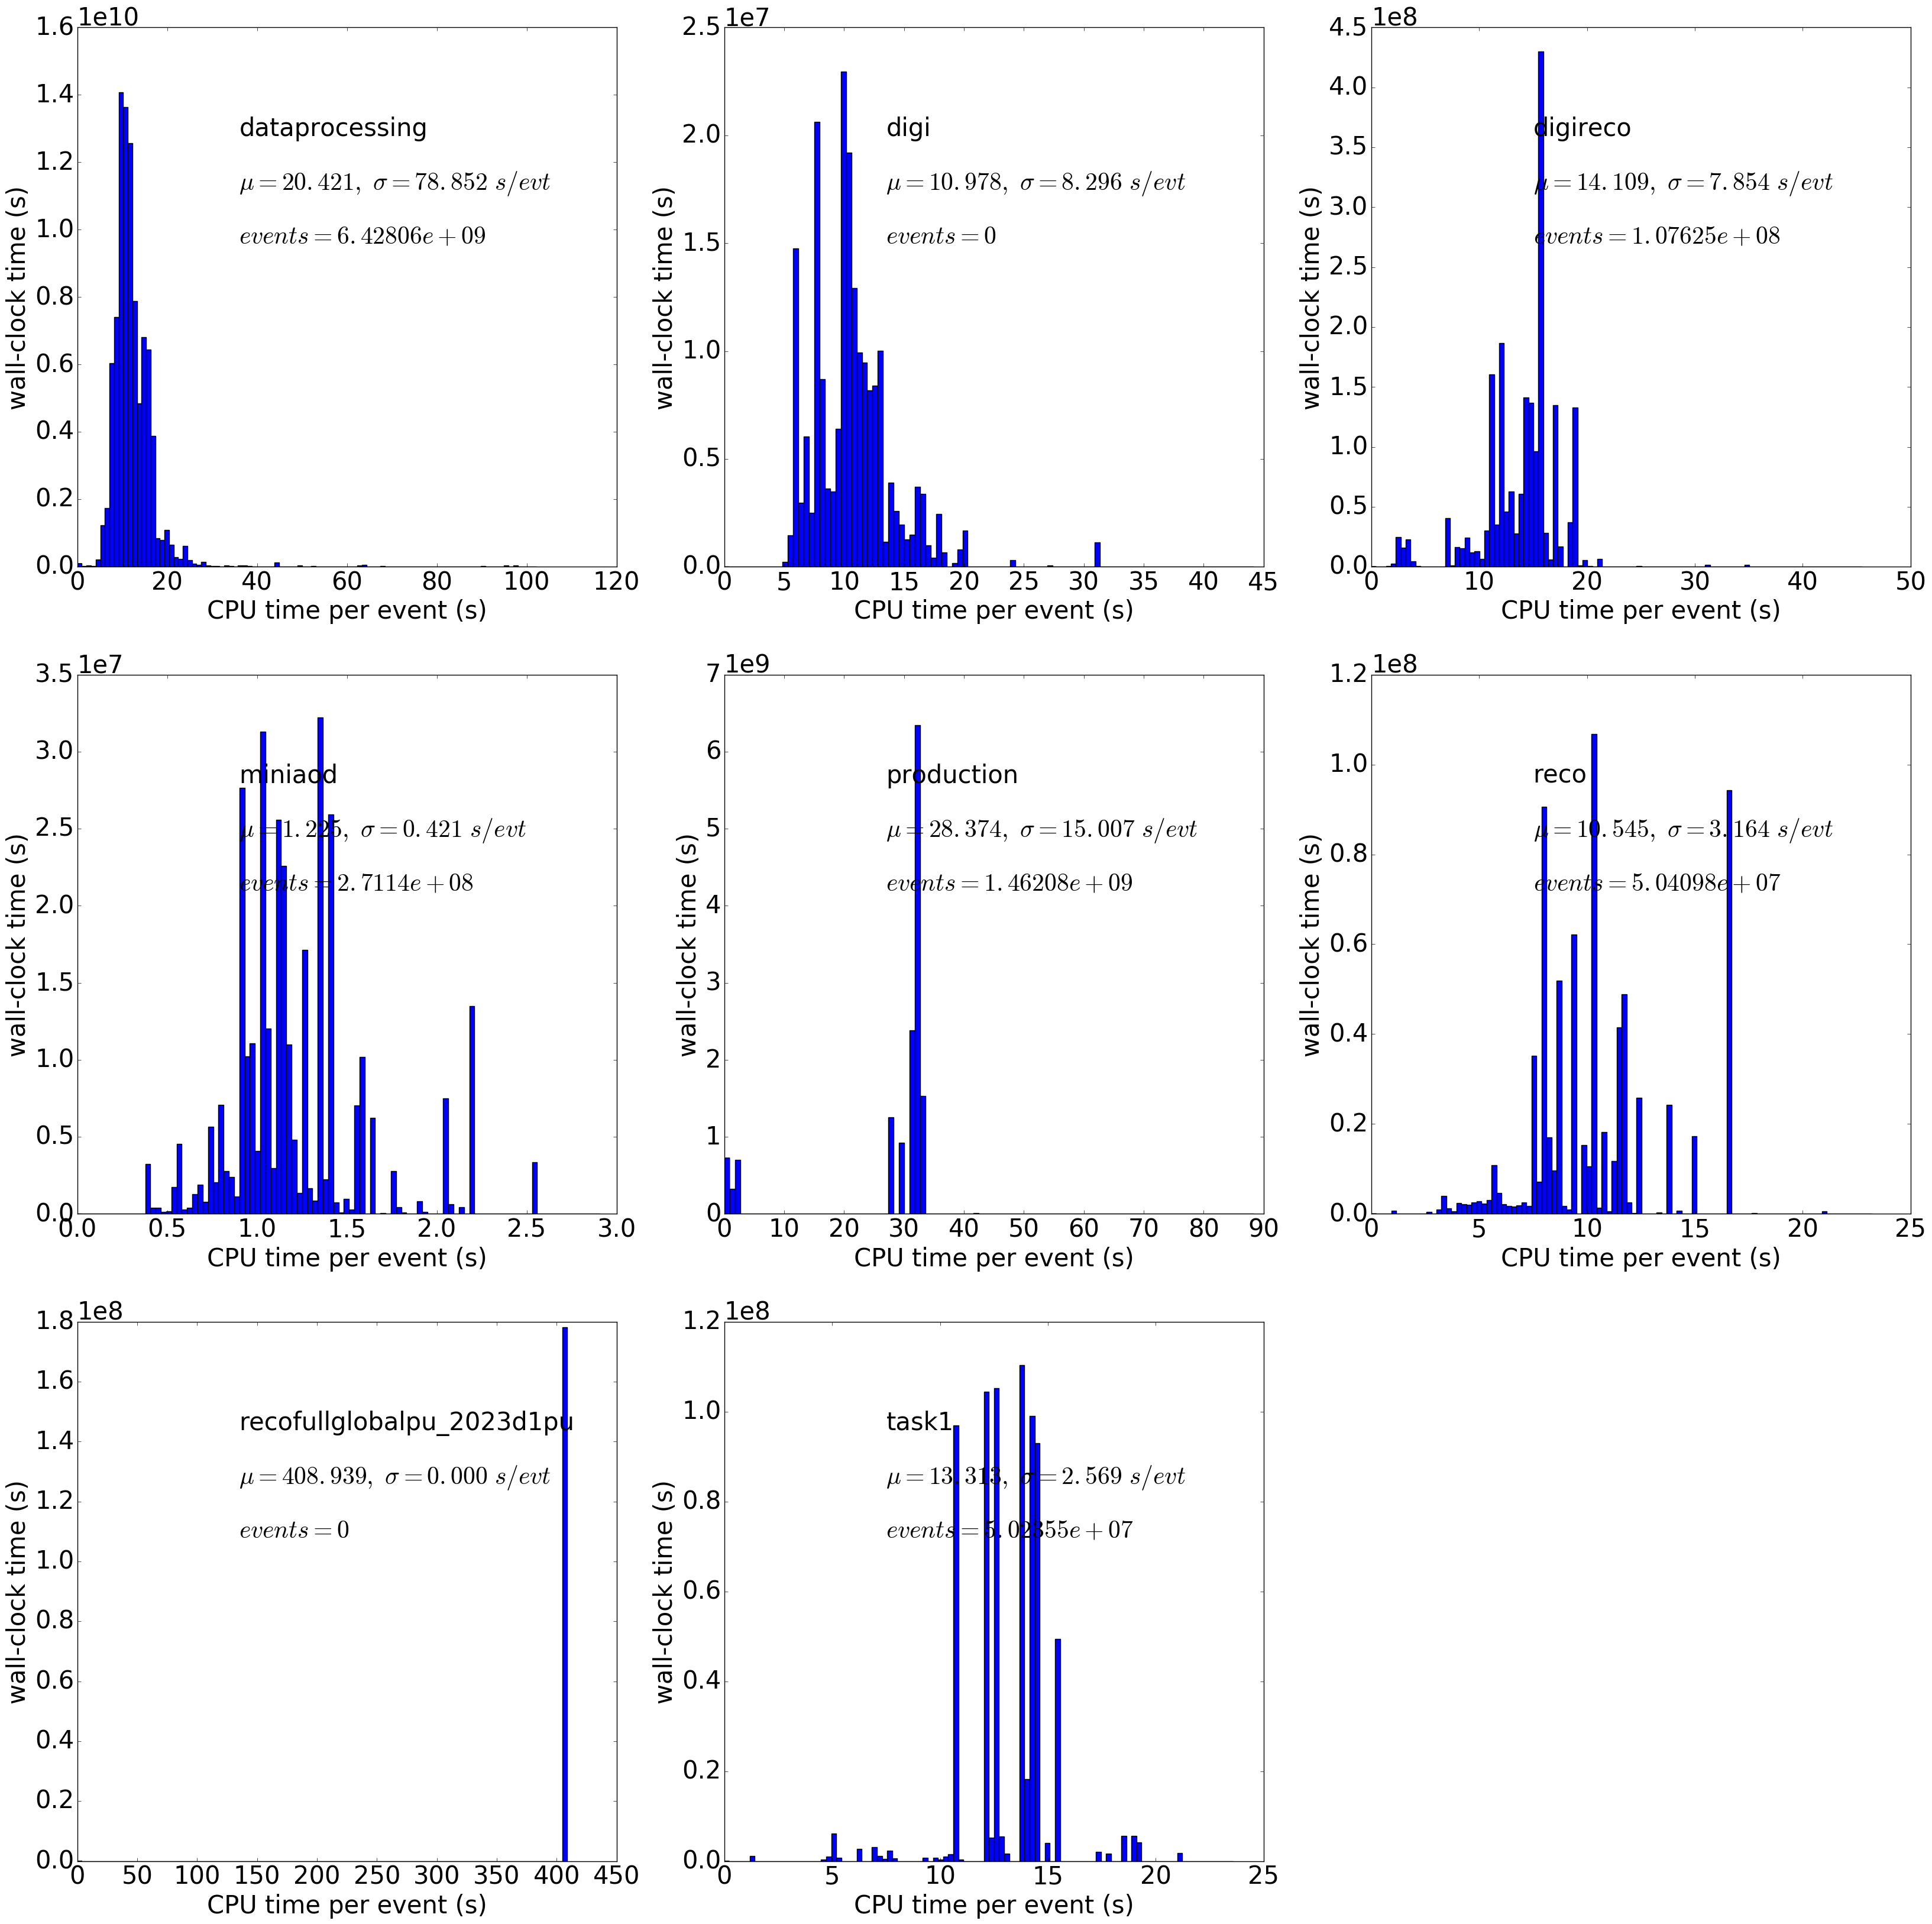

In [117]:
fig = plt.figure(figsize=(40,40))
plt.rcParams.update({'font.size': 30})
var = 'cpuevt_avg'
log_scale = False
wc_tot = df[df.type == 'production']['wc'].sum()
i = 1

grouped = df[df.type == 'production'].groupby(['tasktype'], as_index=False)

for (p), g in grouped:
    if g['wc'].sum() < 0.001 * wc_tot:
        continue
    mean = np.average(g[var], weights=g['wc'])   # average time weighted with no. of events
    std = math.sqrt(np.average((g[var] - mean)**2, weights=g['wc']))
    range = [0., mean + min(mean, std) * 4.]
    sp = plt.subplot(3, 3, i)
    plt.hist(g[var].tolist(), bins=100, range=range, weights=g['wc'].tolist(), log=log_scale)   # integral is total no. of events
    plt.xlabel('CPU time per event (s)')
    plt.ylabel('wall-clock time (s)')
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    stats = r'$\mu=%.3f,\ \sigma=%.3f\ s/evt$' % (mean, std)
    stats2 = r'$\mathit{events}=%g$' % g['evts'].sum()
    if log_scale:
        plt.text(t_x(.3), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.8, p)
        plt.text(t_x(.3), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.7, stats)
        plt.text(t_x(.3), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.6, stats2)
    else:
        plt.text(t_x(.3), t_y(.8), p)
        plt.text(t_x(.3), t_y(.7), stats)
        plt.text(t_x(.3), t_y(.6), stats2)
    i += 1

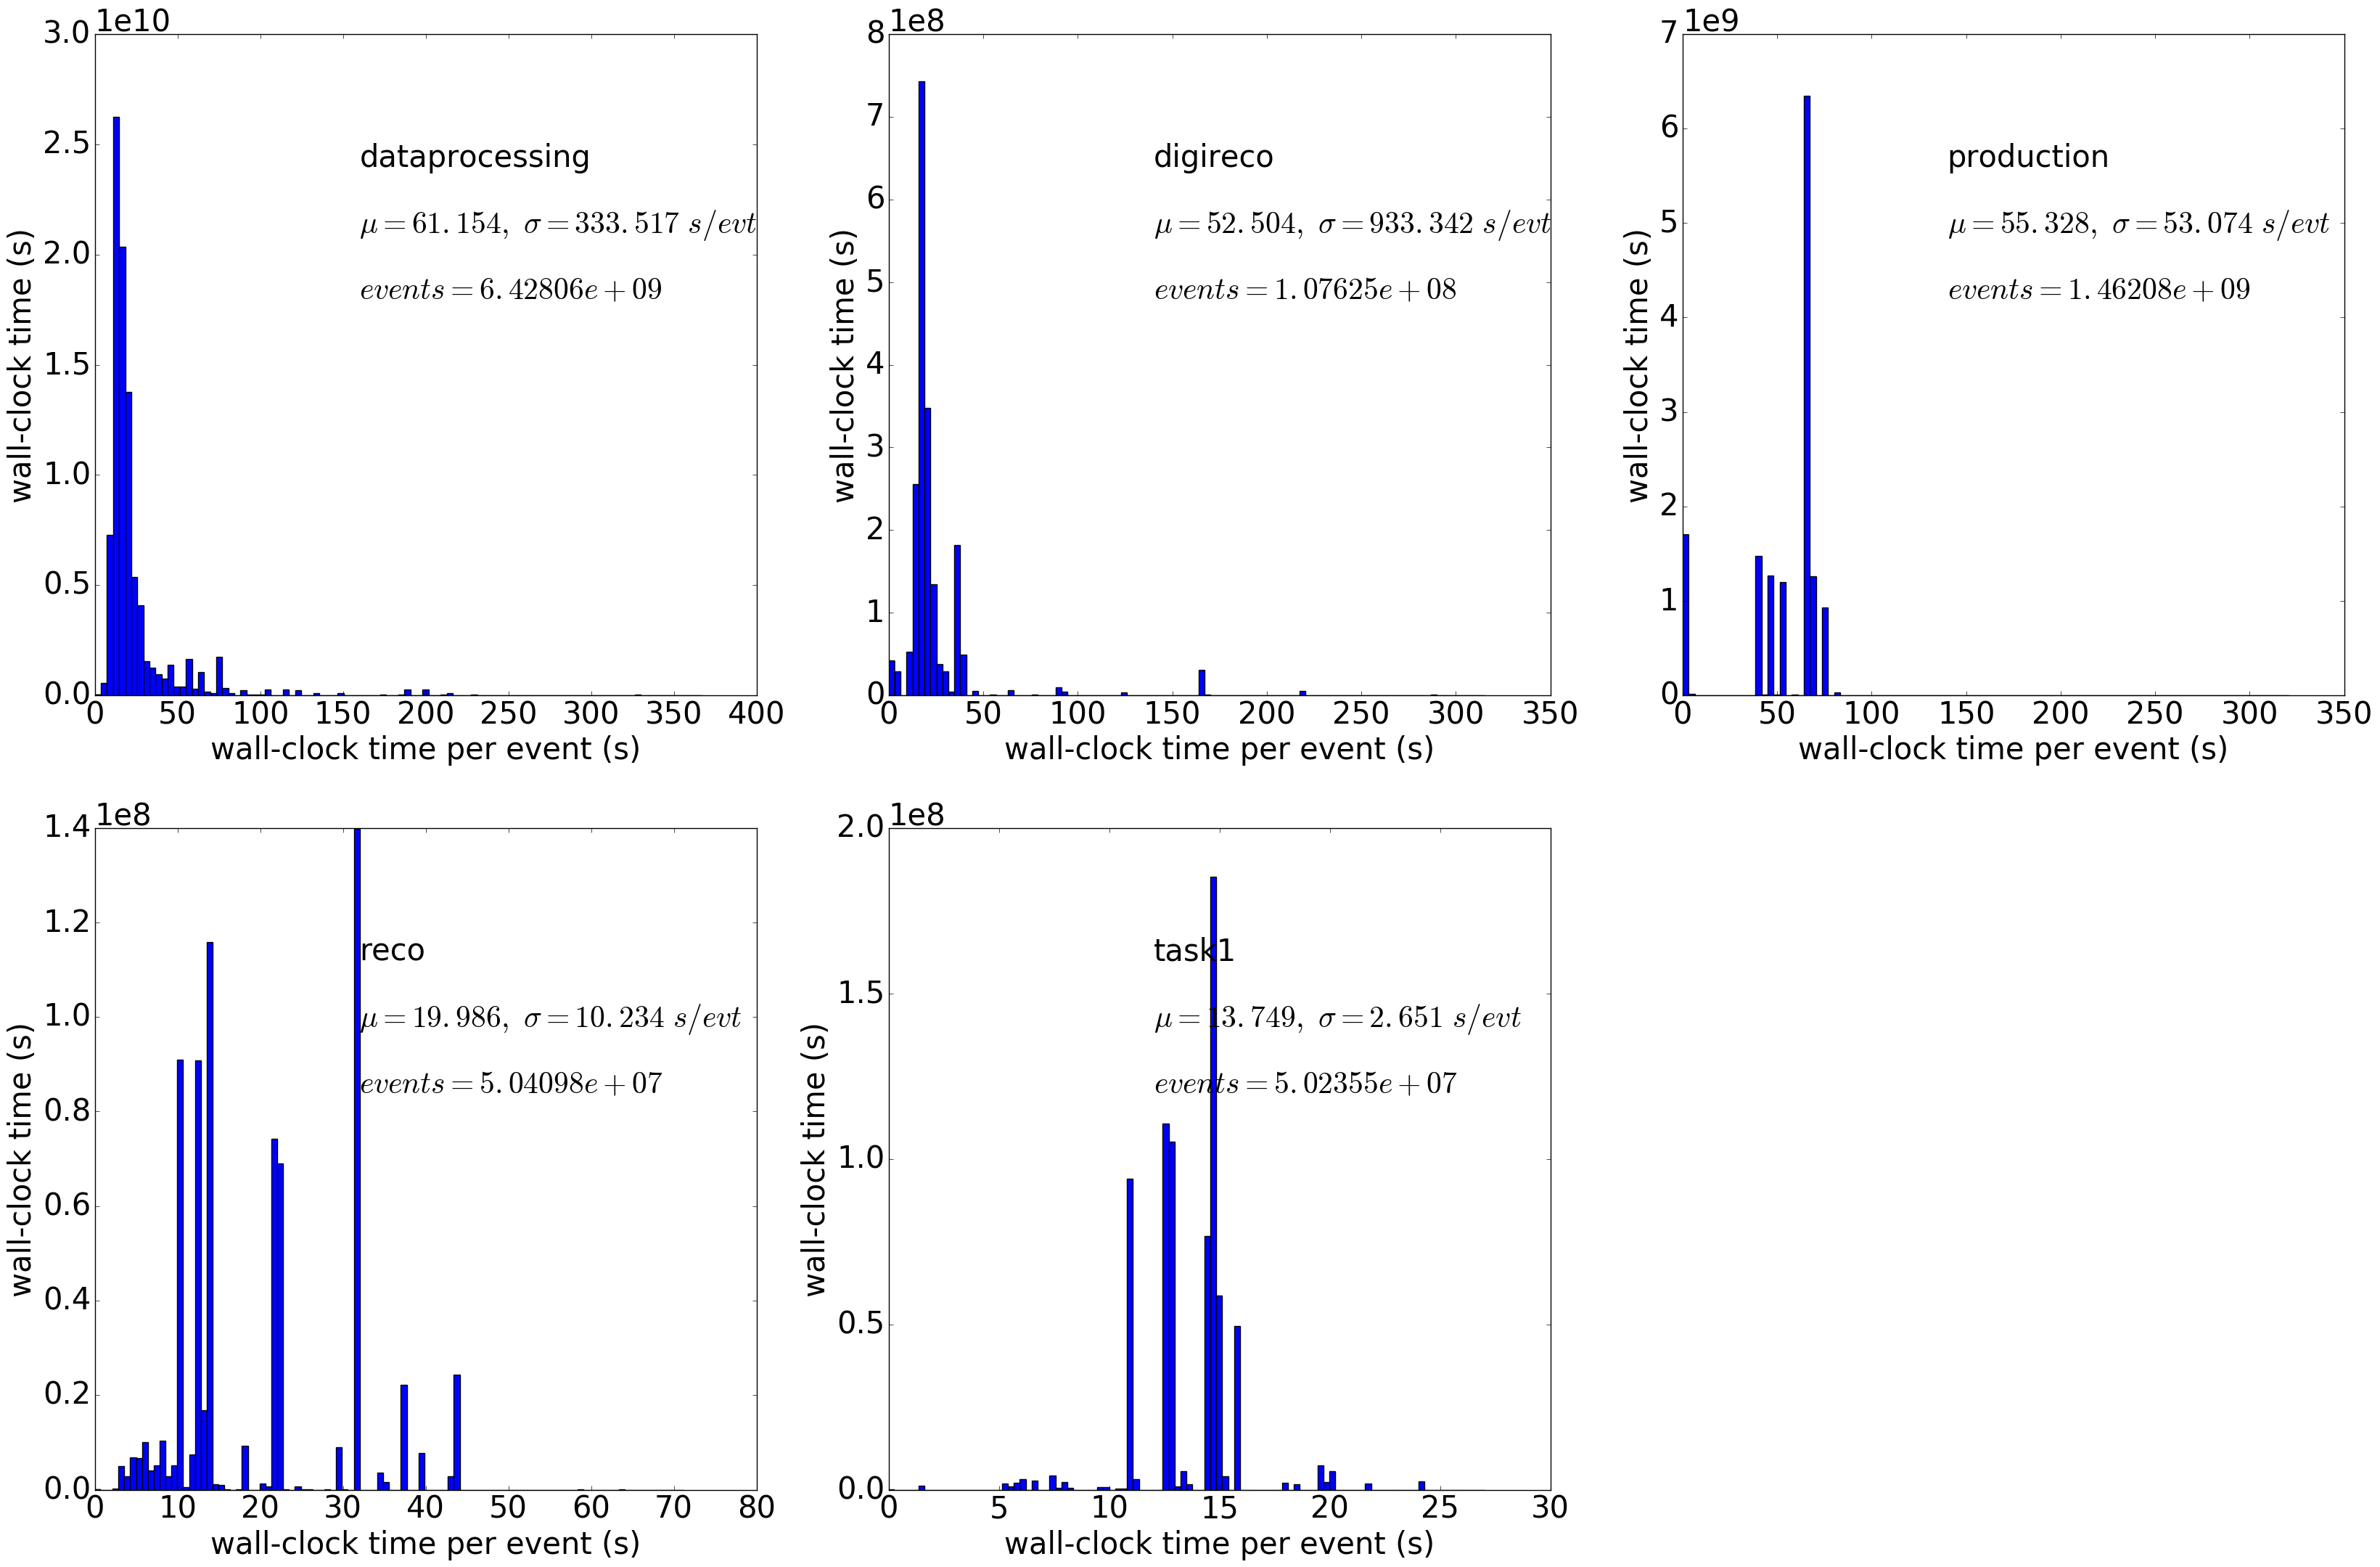

In [118]:
fig = plt.figure(figsize=(40,40))
plt.rcParams.update({'font.size': 30})
var = 'wallevt_avg'
log_scale = False
wc_tot = df[df.type == 'production']['wc'].sum()
i = 1

grouped = df[df.type == 'production'].groupby(['tasktype'], as_index=False)

for (p), g in grouped:
    if g['wc'].sum() < 0.006 * wc_tot:
        continue
    mean = np.average(g[var], weights=g['wc'])   # average time weighted with no. of events
    std = math.sqrt(np.average((g[var] - mean)**2, weights=g['wc']))
    range = [0., mean + min(mean, std) * 5.]
    sp = plt.subplot(3, 3, i)
    plt.hist(g[var].tolist(), bins=100, range=range, weights=g['wc'].tolist(), log=log_scale)   # integral is total no. of events
    plt.xlabel('wall-clock time per event (s)')
    plt.ylabel('wall-clock time (s)')
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    stats = r'$\mu=%.3f,\ \sigma=%.3f\ s/evt$' % (mean, std)
    stats2 = r'$\mathit{events}=%g$' % g['evts'].sum()
    if log_scale:
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.8, p)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.7, stats)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.6, stats2)
    else:
        plt.text(t_x(.4), t_y(.8), p)
        plt.text(t_x(.4), t_y(.7), stats)
        plt.text(t_x(.4), t_y(.6), stats2)
    i += 1

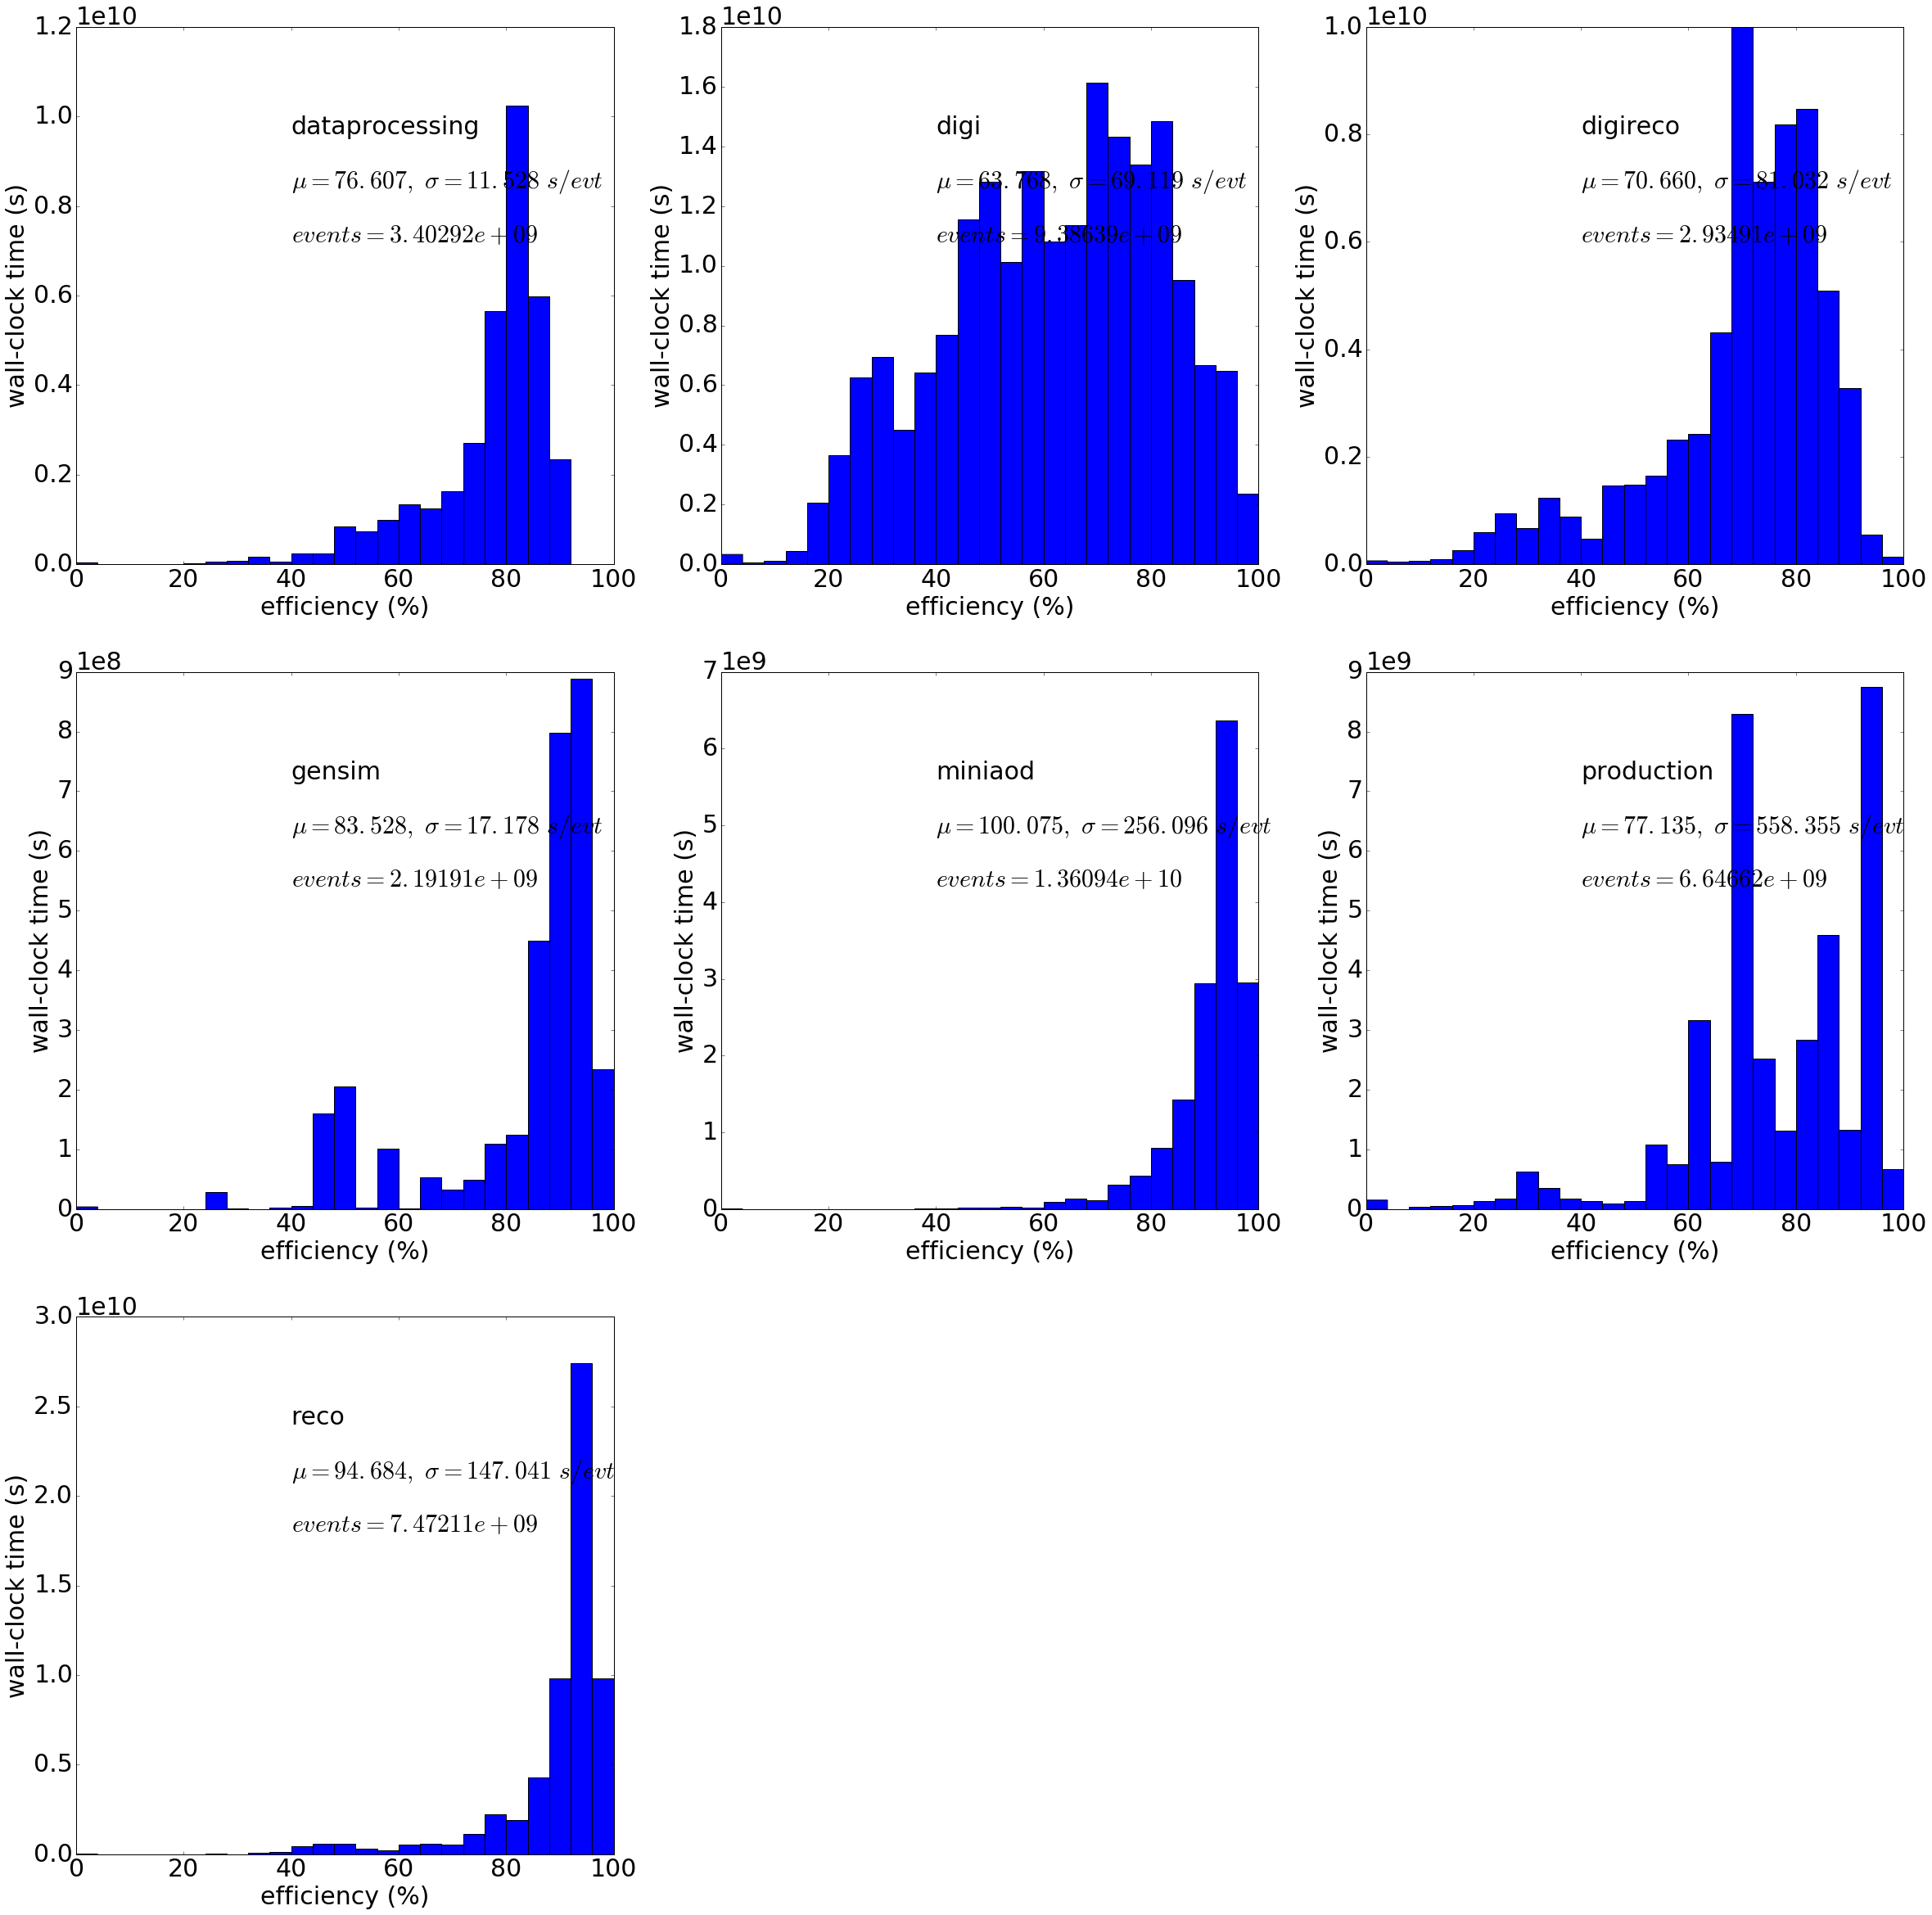

In [41]:
fig = plt.figure(figsize=(40,40))
plt.rcParams.update({'font.size': 30})
var = 'eff'
log_scale = False
wc_tot = df['wc'].sum()
i = 1

grouped = df.groupby(['processingtype'], as_index=False)

for (p), g in grouped:
    if g['wc'].sum() < 0.006 * wc_tot:
        continue
    mean = np.average(g[var], weights=g['wc'])   # average time weighted with no. of events
    std = math.sqrt(np.average((g[var] - mean)**2, weights=g['wc']))
    range = [0., 100.]
    sp = plt.subplot(3, 3, i)
    plt.hist(g[var].tolist(), bins=25, range=range, weights=g['wc'].tolist(), log=log_scale)   # integral is total no. of events
    plt.xlabel('efficiency (%)')
    plt.ylabel('wall-clock time (s)')
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    stats = r'$\mu=%.3f,\ \sigma=%.3f\ s/evt$' % (mean, std)
    stats2 = r'$\mathit{events}=%g$' % g['evts'].sum()
    if log_scale:
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.8, p)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.7, stats)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.6, stats2)
    else:
        plt.text(t_x(.4), t_y(.8), p)
        plt.text(t_x(.4), t_y(.7), stats)
        plt.text(t_x(.4), t_y(.6), stats2)
    i += 1

In [38]:
ptype = 'miniaod'

# Find JEDI task with given parameters
tot_evts = dict()
grouped = df.groupby(['processingtype', 'request'], as_index=False)
for (p, j), g in grouped:
    if (p != ptype): continue
    tot_evts[j] = g['evts'].sum()

biggest_tasks = sorted(tot_evts, key=tot_evts.get, reverse=True)
a = biggest_tasks[:1]
random_task = np.random.choice(a, 1)
print random_task

['pdmvserv_sus-runiispring15miniaodv2-00479_00409_v0__160329_003600_9430']


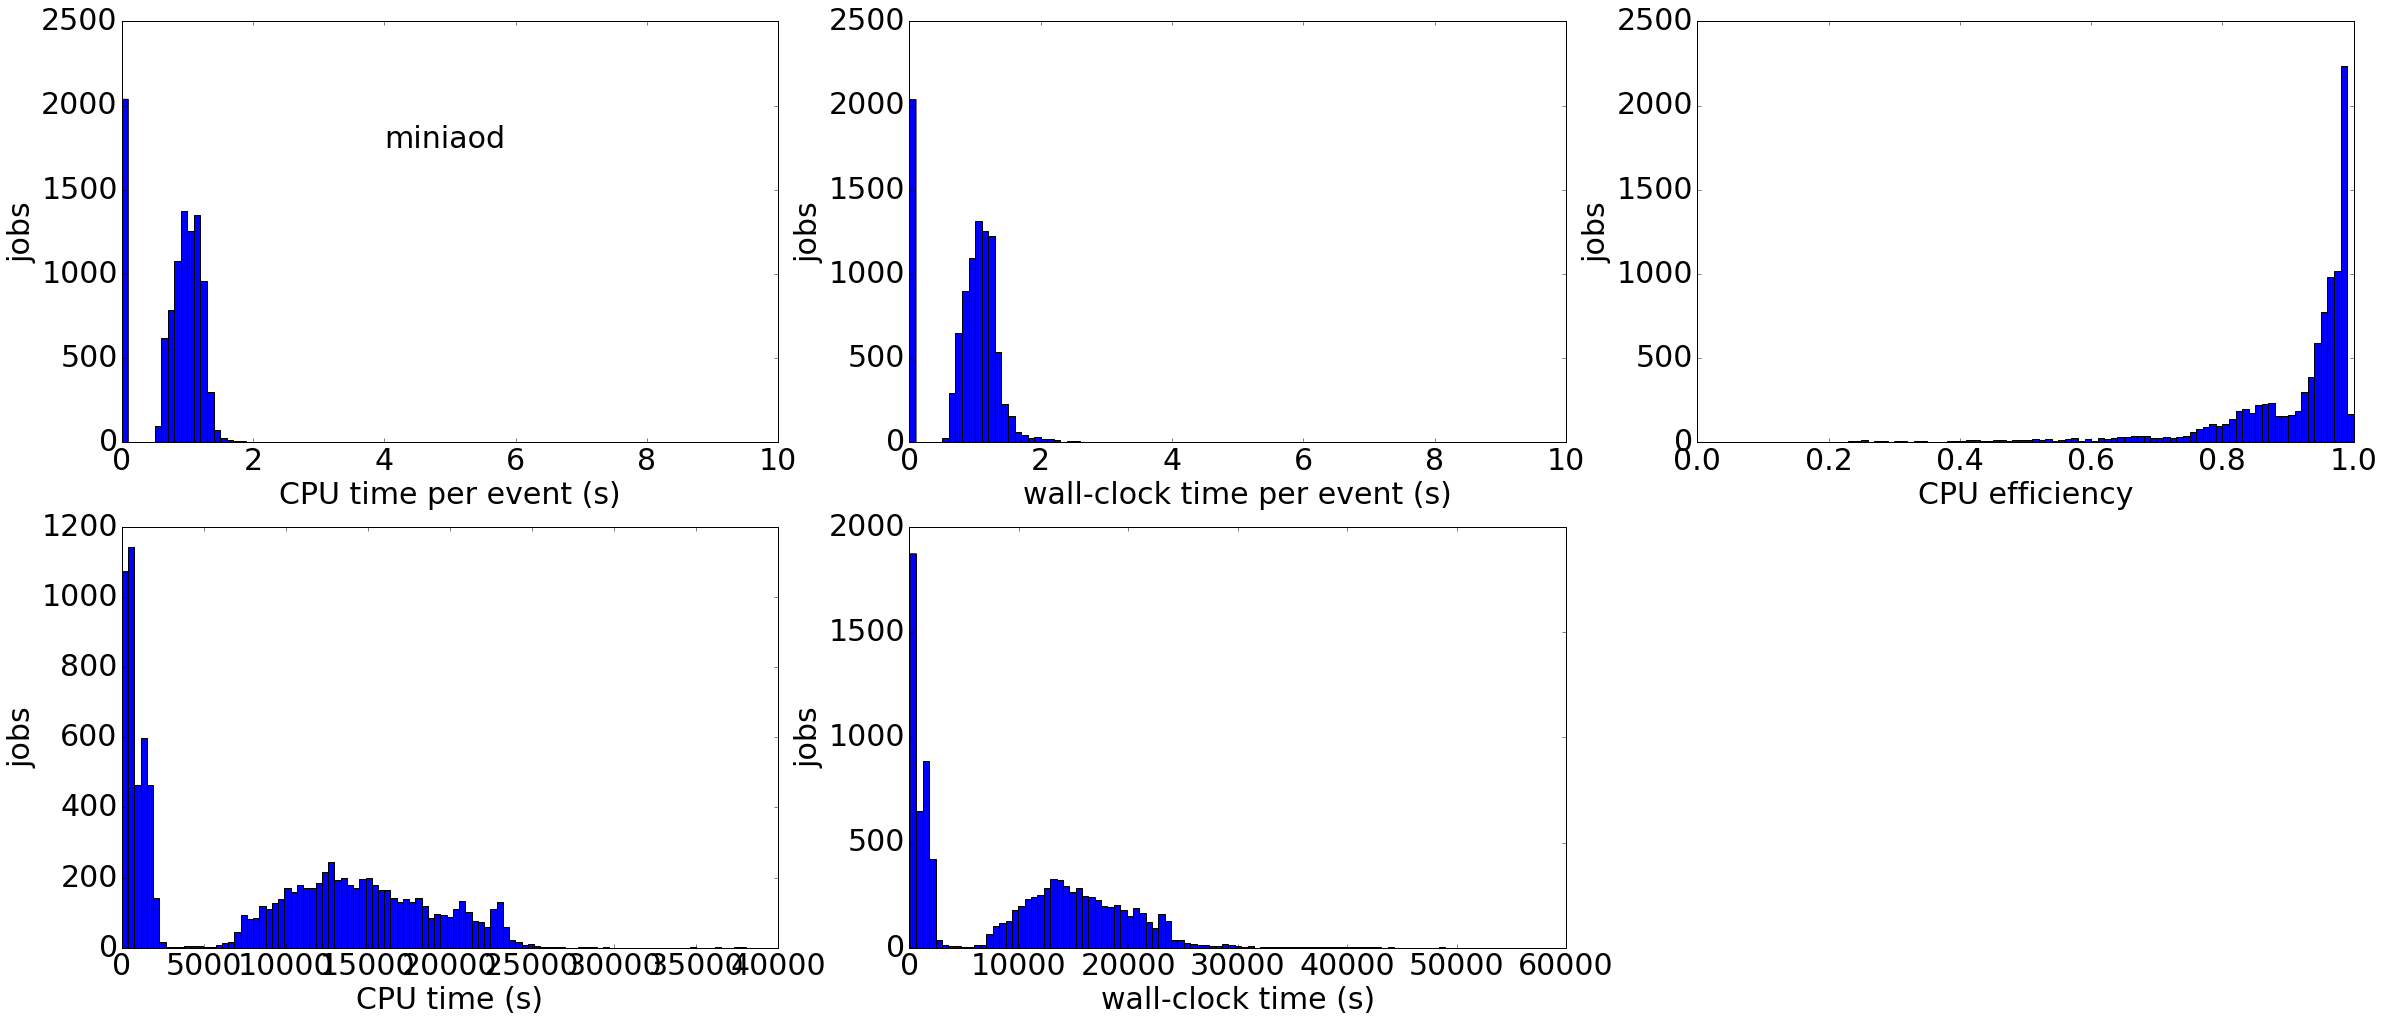

In [41]:
fig2 = plt.figure(figsize=(40,80))
plt.rcParams.update({'font.size': 30})
i = 1
for t in random_task:
    s = {
        "size": 10000,
        "_source": ["CpuTimeHr", "CoreHr", "RequestCpus", "KEvents", "CpuEff"],
        "query": {
            "filtered": {
                "filter": {
                    "bool": {
                        "must": [
                            { "match": { "WMAgent_RequestName": t}},
                            { "range": {"KEvents": {"ge": 0.0001}}},
                            { "range": {"CoreHr": {"gte": 0.0010}}},
                            { "match": {"Status": "completed"}}
                        ]
                    }
                }
            }
        }
    }
    res = es.search(index=ind, body=s, request_timeout=300)
    cputimes = list()
    wctimes = list()
    effs = list()
    cpus = list()
    wcs = list()
    for h in res['hits']['hits']:
        vars = h['_source']
        cpuevt = vars['CpuTimeHr'] / vars['KEvents'] * 3.6
        wcevt = vars['CoreHr'] / vars['KEvents'] * 3.6
        eff = vars['CpuEff'] / 100.
        cpu = vars['CpuTimeHr'] * 3600.
        wc = vars['CoreHr'] * 3600.
        cputimes.append(cpuevt)
        wctimes.append(wcevt)
        effs.append(eff)
        cpus.append(cpu)
        wcs.append(wc)
    sp = plt.subplot(9, 3, i)
    plt.hist(cputimes, bins=100, range=[0., 10.])
    plt.xlabel('CPU time per event (s)')
    plt.ylabel('jobs')
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    plt.text(t_x(0.4), t_y(.7), ptype)
#    stats = r'$req=%s$' % (t)
#    plt.text(t_x(.4), t_y(.6), stats)
    sp = plt.subplot(9, 3, i+1)
    plt.hist(wctimes, bins=100, range=[0., 10.])
    plt.xlabel('wall-clock time per event (s)')
    plt.ylabel('jobs')
    sp = plt.subplot(9, 3, i+2)
    plt.hist(effs, bins=100, range=[0., 1.])
    plt.xlabel('CPU efficiency')
    plt.ylabel('jobs')
    sp = plt.subplot(9, 3, i+3)
    plt.hist(cpus, bins=100, range=None)
    plt.xlabel('CPU time (s)')
    plt.ylabel('jobs')
    sp = plt.subplot(9, 3, i+4)
    plt.hist(wcs, bins=100, range=None)
    plt.xlabel('wall-clock time (s)')
    plt.ylabel('jobs')
    i += 5